In [ ]:
# Import Libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Layer, Input, Dense, GaussianNoise, BatchNormalization, Lambda
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras import backend

import scipy
from scipy import special
from scipy.special import erf
import matplotlib.pyplot as plt

# Set random seeds
np.random.seed(1)

In [ ]:
# Transmitter parameters
M=16
k = np.log(2)*(M)
EbNo_values = list(np.arange(0, 11, 1))

# generating data of size N
N=250000
data = []

# Letting user choose between power-constraints, avg_pow and equal_pow
inp=input("QAM or PSK? ")
if inp == "QAM":
  power = 'avg_pow'
elif inp == "PSK":
  power = 'equal_pow'
else:
  print("invalid")

# creating one-hot vectors dataset
for i in range(0, N) :
  temp = np.zeros(M)
  hot_index = np.random.randint(M)
  temp[hot_index] = 1
  data.append(temp)

# convert list ot an array
data = np.array(data)
print(data)
print(data.shape)

QAM or PSK? PSK
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(250000, 16)


In [ ]:
# transmitter layers
input_layer = Input(shape=(M,))
TX_hidden_layer_1=Dense(M, activation = 'relu')(input_layer)
TX_hidden_layer_2=Dense(8, activation = 'relu')(TX_hidden_layer_1)
TX_hidden_layer_3=Dense(2, activation = 'linear')(TX_hidden_layer_2)

# normalization layer, loops to choose between power constraints
if power == 'avg_pow':
  print('Using average power')
  norm_layer=BatchNormalization(center=False, scale=False)(TX_hidden_layer_3)
else:
  print('Using equal power')
  norm_layer=Lambda(lambda x: backend.l2_normalize(x, axis=1))(TX_hidden_layer_3)

# channel layer
channel = GaussianNoise(stddev=0.05) (norm_layer, training=True)

#receiver layers
output_layer1=Dense(M, activation='linear')(channel)
output_layer2=Dense(M, activation='relu')(output_layer1)
output_layer3=Dense(M, activation='softmax')(output_layer2)

autoencoder = Model(input_layer, output_layer3)
adam = Adam(learning_rate = 0.001)
autoencoder.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

print(autoencoder.summary())
print(output_layer3)

Using equal power
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 2)                 18        
                                                                 
 lambda (Lambda)             (None, 2)                 0         
                                                                 
 gaussian_noise (GaussianNo  (None, 2)                 0         
 ise)                                                            
                                           

In [ ]:
# training autoencoder
history = autoencoder.fit(data, data, epochs=50, batch_size=1024, validation_split=0.3)

results = autoencoder.evaluate(data, data, batch_size=1024)
print('test_loss, test_acc:', results)



NameError: ignored

1/1 [==============================] - 0s 104ms/step
[[-0.13992518  0.63651675]
 [-1.3325746   0.890736  ]
 [-0.40137446 -1.8841213 ]
 [ 0.35175624  1.6142707 ]
 [ 1.0674658   1.1796848 ]
 [ 1.6394752   0.5435138 ]
 [-1.5318003  -0.02766692]
 [ 1.2671899  -1.1337453 ]
 [-0.55945104 -0.76261884]
 [ 1.2633418  -0.28331625]
 [-0.36979648 -0.0085388 ]
 [ 0.22348326 -0.42603016]
 [ 0.41027772  0.23743744]
 [-1.7417668  -0.83581364]
 [-0.6848576   1.4519293 ]
 [ 0.46016014 -1.4688002 ]]


<function matplotlib.pyplot.show(close=None, block=None)>

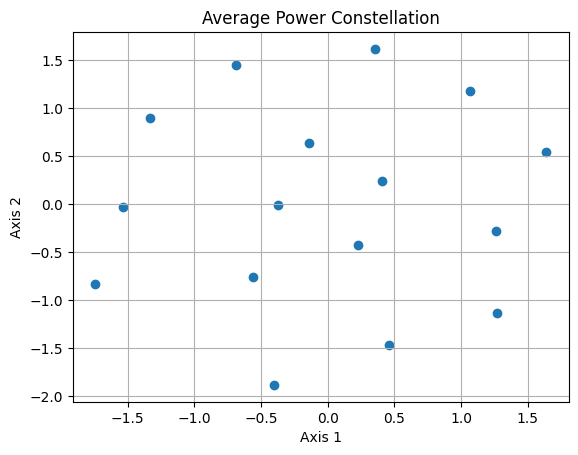

In [ ]:
#create transmitter model from trained autoencoder model
transmitter_model = Model(input_layer, norm_layer)

#create receiver model from trained autoencoder model
receiver_model = Model(channel, output_layer3)

#create receiver model from trained autoencoder model
all_vecs = []
for i in range(0,M):
  temp = np.zeros(M)
  temp[i] = 1
  all_vecs.append(temp)
all_vecs = np.array(all_vecs)

const_coords = transmitter_model.predict(all_vecs)
print(const_coords)
plt.scatter(const_coords[:,0], const_coords[:,1])
plt.xlabel('Axis 1')
plt.ylabel('Axis 2')
plt.title('Average Power Constellation')
plt.grid(axis='both')
plt.show


7813/7813 [==============================] - 10s 1ms/step


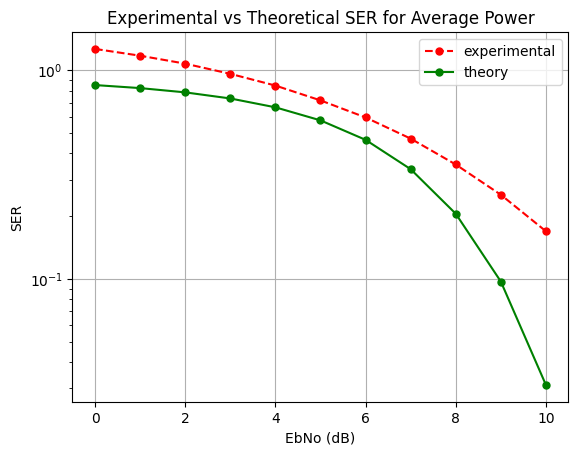

In [ ]:
#generating data for checking SER
test_data = []
for i in range(0,N):
	temp = np.zeros(M)
	hot_index = np.random.randint(M)
	temp[hot_index] = 1
	test_data.append(temp)

test_data = np.array(test_data)

def qfunc(x):
    return 0.5-0.5*erf(x/np.sqrt(2))

# select the range of noise standard deviation
EbNo_values = list(np.arange(0, 11, 1))
SERauto = [None]*len(EbNo_values)
SERth = [None]*len(EbNo_values)

for i in range(0,len(EbNo_values)):
  no_errors=0
  EbNo = 10**(EbNo_values[i]/10)
  SNR = EbNo_values[i] + 10*np.log10(k)
  if power == 'avg_pow':
    SERth[i] = 1-(1-((2*np.sqrt(M)-2)/np.sqrt(M)*qfunc(np.sqrt(3*np.log2(M))/(M-1)*EbNo)))**2
  else:
    SERth[i] = 2*qfunc(np.sqrt(2*k*EbNo)*np.sin(np.pi/M))

  noise_std = np.sqrt(1/(2*EbNo))
  noise = noise_std * np.random.randn(N,2)
  transmitted_signal = transmitter_model.predict(test_data)
  received_signal = transmitted_signal + noise
  pred_transmitted_signal = receiver_model.predict(received_signal)
  pred_output = pred_transmitted_signal / pred_transmitted_signal.max(axis=1) [:,None]
  pred_output = pred_output.astype(int)
  no_errors = (pred_output != test_data)
  no_errors = no_errors.astype(int).sum()
  SERauto[i] = no_errors / N


# plot SER vs EbNo
plt.plot(EbNo_values, SERauto, color='red', linestyle='dashed', marker='o', markersize=5, label = 'experimental')
plt.plot(EbNo_values, SERth, color='green', linestyle='solid', marker='o', markersize=5, label = 'theory')
plt.legend(loc='upper right',ncol = 1);
plt.title("Experimental vs Theoretical SER for Average Power")
plt.yscale('log')
plt.xlabel('EbNo (dB)')
plt.ylabel('SER')
plt.grid()
plt.show()